# Library Import


In [69]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1. Dataset Import


In [3]:
# Load the previously extracted features
dataset = joblib.load('../a9_dataset/svm_data/full_features.pkl')
dataset

{'features': array([[-1.96035731e+00, -1.02430713e+00,  1.66992903e-01, ...,
          2.00000000e+00,  2.50000000e+01,  8.77000000e+02],
        [-2.67427540e+00, -2.98963666e-01, -3.55513215e-01, ...,
          1.00000000e+00,  4.30000000e+01,  1.51000000e+03],
        [-2.60635567e+00, -5.37102580e-01, -3.76106799e-01, ...,
          0.00000000e+00,  1.00000000e+00,  5.73000000e+02],
        ...,
        [-2.91151571e+00,  1.48994362e+00,  1.74523425e+00, ...,
          0.00000000e+00,  1.70000000e+01,  2.07200000e+03],
        [-2.38359594e+00,  2.65177727e+00,  2.28796029e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.50000000e+01],
        [-7.08929300e-01, -7.41116405e-01,  2.02592969e+00, ...,
          0.00000000e+00,  3.00000000e+00,  8.69000000e+02]],
       shape=(265552, 957)),
 'labels': array([2, 1, 1, ..., 6, 6, 6], shape=(265552,))}

In [4]:
def stratified_sample(ds, num_labels: int=7, cap: int=8000):
  features = ds['features']
  labels = ds['labels']
  
  keep_indices = []
  
  for label in range(num_labels):
    indices = np.where(label == labels)[0]
    
    np.random.shuffle(indices)
    
    keep_indices.extend(indices[:cap])
  
  np.random.shuffle(keep_indices)
  
  return features[keep_indices], labels[keep_indices]

In [5]:
# Split to X and y
X, y = stratified_sample(dataset)

# 2. Feature Engineering


In [6]:
# Random state to ensure that 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3, shuffle=True)

In [7]:
# Scaling as HOG and LTP outputs different range of values
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Modeling


In [8]:
ovr_linear_svm = LinearSVC(
  class_weight='balanced',
  dual=False,
  verbose=True,
  max_iter=10000,
  random_state=42,
).fit(X_train, y_train)

[LibLinear]

In [ ]:
linear_svm = LinearSVC(
  class_weight='balanced',
  dual=False,
  verbose=True,
  max_iter=10000,
  random_state=42,
)

ovo_linear_svm = OneVsOneClassifier(linear_svm, n_jobs=-1).fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

# 4. Evaluation


In [10]:
ovr_predicted_y = ovr_linear_svm.predict(X_test)

ovr_report = classification_report(y_test, ovr_predicted_y, zero_division=0.0)
ovr_cm = confusion_matrix(y_test, ovr_predicted_y)

In [11]:
ovo_predicted_y = ovo_linear_svm.predict(X_test)

ovo_report = classification_report(y_test, ovo_predicted_y, zero_division=0.0)
ovo_cm = confusion_matrix(y_test, ovo_predicted_y)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      2400
           1       0.85      0.83      0.84      2400
           2       0.83      0.79      0.81      2400
           3       0.80      0.80      0.80      2400
           4       0.80      0.88      0.84       527
           5       0.85      0.97      0.91       166
           6       0.81      0.87      0.84      2400

    accuracy                           0.81     12693
   macro avg       0.81      0.84      0.82     12693
weighted avg       0.81      0.81      0.81     12693

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      2400
           1       0.82      0.82      0.82      2400
           2       0.79      0.79      0.79      2400
           3       0.78      0.79      0.78      2400
           4       0.91      0.87      0.89       527
           5       0.96      0.91      0.93       166
           6       0.82 

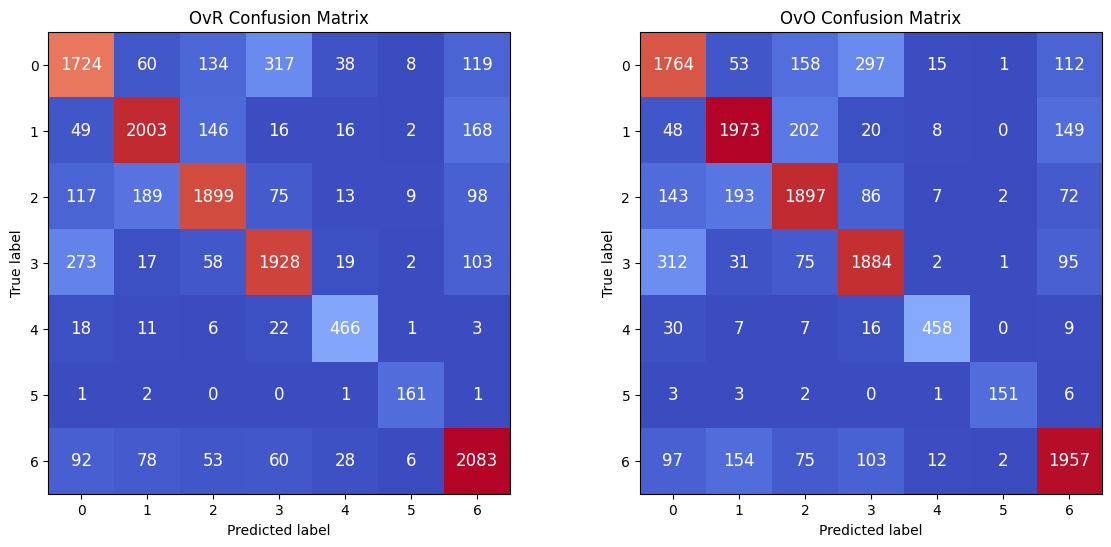

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay.from_predictions(
  y_test,
  ovr_predicted_y,
  ax=ax1,
  cmap='coolwarm',
  colorbar=False,
  text_kw={'color': 'white', 'fontsize': 12},
)
ax1.set_title('OvR Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(
  y_test,
  ovo_predicted_y,
  ax=ax2,
  cmap='coolwarm',
  colorbar=False,
  text_kw={'color': 'white', 'fontsize': 12},
)
ax2.set_title('OvO Confusion Matrix')

print(ovr_report)
print(ovo_report)

In [41]:
ovr_predicted_y_scores = softmax(ovr_linear_svm.decision_function(X_test), axis=1)
ovo_predicted_y_scores = softmax(ovo_linear_svm.decision_function(X_test), axis=1)

print(f"OvR ROC-AUC Scores: {roc_auc_score(y_test, ovr_predicted_y_scores, multi_class='ovr', average='macro')}")
print(f"OvO ROC-AUC Scores: {roc_auc_score(y_test, ovo_predicted_y_scores, multi_class='ovo', average='macro')}")

OvR ROC-AUC Scores: 0.970252316870115
OvO ROC-AUC Scores: 0.9581571034603384


In [44]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

fpr_ovr, tpr_ovr, _ = roc_curve(y_test_bin.ravel(), ovr_predicted_y_scores.ravel())
auc_ovr = auc(fpr_ovr, tpr_ovr)

fpr_ovo, tpr_ovo, _ = roc_curve(y_test_bin.ravel(), ovo_predicted_y_scores.ravel())
auc_ovo = auc(fpr_ovo, tpr_ovo)

[]

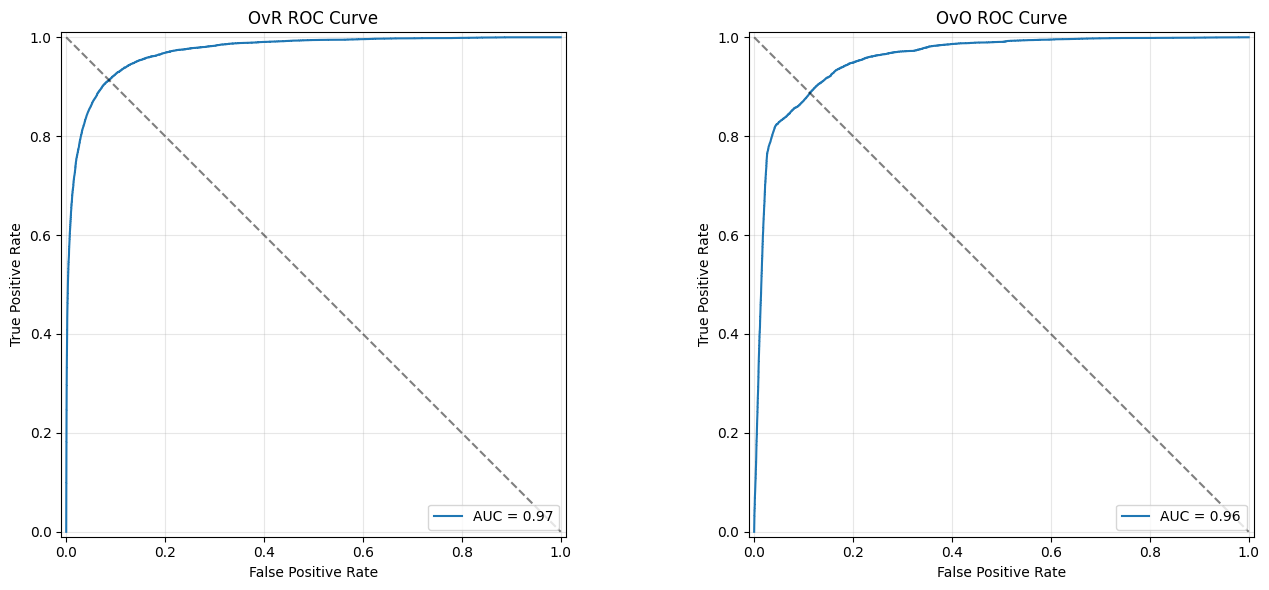

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

RocCurveDisplay(fpr=fpr_ovr, tpr=tpr_ovr, roc_auc=auc_ovr).plot(ax=ax1)
ax1.set_title('OvR ROC Curve')
ax1.grid(alpha=0.3)
ax1.plot([0, 1], [1, 0], 'k--', alpha=0.5)

RocCurveDisplay(fpr=fpr_ovo, tpr=tpr_ovo, roc_auc=auc_ovo).plot(ax=ax2)
ax2.set_title('OvO ROC Curve')
ax2.grid(alpha=0.3)
ax2.plot([0, 1], [1, 0], 'k--', alpha=0.5)

plt.tight_layout()
plt.plot()

# 5. Export


In [75]:
scaler_onnx = to_onnx(
  scaler,
  initial_types=[('float_input', FloatTensorType([None, 957]))],
  target_opset=12,  
)

with open("svm_sstw/scaler.onnx", "wb") as f:
  f.write(scaler_onnx.SerializeToString())

In [74]:
svm_onnx = to_onnx(
  ovr_linear_svm,
  initial_types=[('float_input', FloatTensorType([None, 957]))],
  target_opset=12,  
)

with open("svm_sstw/ovr_linear_svc.onnx", "wb") as f:
  f.write(svm_onnx.SerializeToString())